In [418]:
import numpy as np
import matplotlib.pyplot as plt

import soundfile as sf
import librosa
import librosa.display

import os
import time

from __future__ import print_function

import sklearn
from sklearn.decomposition import PCA


In [419]:
def features_extracted(file):
    #logic behind frame_size and frame_shift explained in report. 
    frame_size = 2048 
    frame_shift = 512 
    signal, samplingrate = librosa.load(file,sr=None)

    mfccs = librosa.feature.mfcc(signal, samplingrate, n_mfcc=24, hop_length=frame_shift, n_fft=frame_size)
    mfccs = mfccs/mfccs.max()

    zero_crossings = librosa.zero_crossings(signal, pad=False)
    zero_crossings = zero_crossings/zero_crossings.max()

    spectral_centroids = librosa.feature.spectral_centroid(signal, sr=samplingrate)[0]
    spectral_centroids =  spectral_centroids/ spectral_centroids.max()

    spectral_rolloff = librosa.feature.spectral_rolloff(signal, sr=samplingrate)[0]
    spectral_rolloff = spectral_rolloff/spectral_rolloff.max()

    chroma_feature = librosa.feature.chroma_stft(signal,sr=samplingrate,hop_length=frame_shift,n_fft=frame_size)
    chroma_feature = chroma_feature/chroma_feature.max()

    rms_feature =librosa.feature.rms(signal, frame_length=frame_size, hop_length=frame_shift)
    rms_feature = rms_feature/rms_feature.max()

    #feature concatenation
    mfccs = np.resize(mfccs,[27,9963])
    mfccs[24,:] = spectral_centroids
    mfccs[25,:] = spectral_rolloff
    #mfccs[26,:] = zero_crossings
    mfccs[26,:] = np.transpose(rms_feature[:,1])


    '''
    mfccs = np.resize(mfccs,[37,9963])
    
    for i in range(12):
        mfccs[24:35] = chroma_feature[i,:]
    mfccs[36,:] = np.transpose(rms_feature[:,1])
    '''
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    
    #print(sum(zero_crossings))
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

    librosa.display.specshow(mfccs, sr=samplingrate, x_axis='time', ax=ax[0])
    ax[0].set(title='mfcc features')
    ax[0].label_outer()

    librosa.display.waveplot(signal, sr=samplingrate, alpha=0.4, ax= ax[1])
    plt.plot(t,sklearn.preprocessing.minmax_scale(spectral_rolloff, axis=0), color='g')
    ax[1].set(title='spectral rolloff')
    ax[1].label_outer() 

    #librosa.display.waveplot(signal, sr=samplingrate, alpha=0.4)
    plt.plot(t,sklearn.preprocessing.minmax_scale(spectral_centroids, axis=0), color='r')
    #ax[2].set(title='spectral centroids')
    #ax[2].label_outer() 

    plt.show()
    return mfccs





In [420]:
def bic_calculation(features,penalty,k):
    x,y = features.shape
    sig = np.cov(features).diagonal()
    
    features_min = np.finfo(np.double).tiny
    eps = np.spacing(5)

    det0 = max(np.prod(np.maximum(sig, eps)), features_min)
    starting = 5
    iteration_range =range(starting,y,k)
    #iterations_length = len(iterations_range) #k delta
    #selective BIC tests 
    thres_param = 100
    if y > 2*thres_param:
        starting = int(y/2)
        iterations_range = range(int(y/2),y,k)
    iterations_length = len(iteration_range) 
    BIC_list = np.zeros(iterations_length)
    iter = 0
    for i in range(starting,y,k):
        first_seg = features[:, 0:i]
        last_seg = features[:, i:y]
        sig1 = np.cov(first_seg).diagonal()
        sig2 = np.cov(last_seg).diagonal()

        det1 = max(np.prod(np.maximum(sig1, eps)), features_min)
        det2 = max(np.prod(np.maximum(sig2, eps)), features_min)

        BIC = penalty*0.5*(-y*np.log(det0)+i*np.log(det1)+(y-i)*np.log(det2))+0.5*(x+0.5*x*(x+1))*np.log(y)
        BIC_list[iter] = BIC
        iter = iter + 1

    minimum_BIC = BIC_list.min()
    mini = BIC_list.argmin()
    if minimum_BIC < 0:
        return range(starting,y,k)[mini]-1
    else:
        return -1


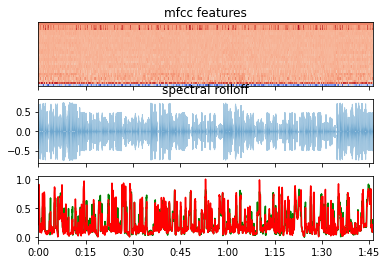

--- 0.11471867561340332 seconds ---


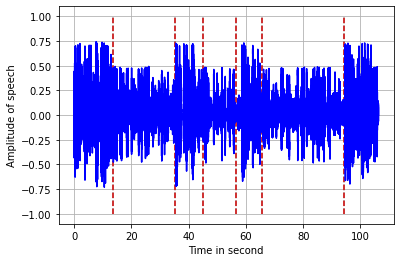

List of segmentation points (Unit: /s) [13.61066667 35.38133333 44.992      56.46933333 65.54666667 94.336     ]


In [421]:
file = 'Interview.wav'
signal, samplingrate = librosa.load(file,sr=None)

frame_size = 2048 
frame_shift = 512

#Feature Extraction from the sound file
features = features_extracted(file)

mfccs = features 
start_time = time.time()
#fixed sliding window params gives 6 
'''    
    wStart = 0
    wGrow = 45  #45 # 30#85
    wEnd = 100 #wStart + wGrow*2'''
wStart = 0
wGrow = 100 #200  #45 # 30#85
wEnd = 200 #300 #wStart + wGrow*2

delta = 25
deltaa = 12
del_mult = 0
m, n = mfccs.shape
    
store_cp = []
index = 0
while wEnd < n:
    featureSeg = mfccs[:, int(wStart):int(wEnd)]

    detBIC = bic_calculation(featureSeg, 1.7, delta)

    index = index + 1
    if (detBIC > 0):
        store_cp.append(wStart + detBIC)
        wStart = wStart +detBIC +wGrow
        wEnd = wStart + wGrow
    else:
        wGrow += int(0.5*deltaa*del_mult) 
        del_mult=del_mult+1
        wEnd = wEnd + wGrow

detected_segment_point = np.array(store_cp)
print("--- %s seconds ---" % (time.time() - start_time))

detected_segment_point = detected_segment_point * frame_shift
detected_segment_point = np.insert(detected_segment_point, 0, 0)
detected_segment_point = np.append(detected_segment_point, len(signal))
iteration_length = range(len(detected_segment_point) - 1)

output_segpoint = []
for i in iteration_length:
    temp = signal[int(detected_segment_point[i]):int(detected_segment_point[i + 1])]
    max_mean = np.mean(temp[temp.argsort()[-800:]])
    if max_mean < 0.005:
        continue
    if detected_segment_point[i + 1] == len(signal):
        continue
    else:
        output_segpoint.append(detected_segment_point[i + 1])

plt.figure('speech segmentation plot')
plt.plot(np.arange(0, len(signal)) / (float)(samplingrate), signal, "b-")

#plotting the segments in the audio data plot
for i in range(len(output_segpoint)):
    plt.vlines(output_segpoint[i] / (float)(samplingrate), -1, 1, colors="c", linestyles="dashed")
    plt.vlines(output_segpoint[i] / (float)(samplingrate), -1, 1, colors="r", linestyles="dashed")
plt.xlabel("Time in second")
plt.ylabel("Amplitude of speech")
plt.grid(True)
plt.show()


save_segpoint = output_segpoint.copy()
# Add the start and the end of the audio file
save_segpoint.insert(0, 0)
#save_segpoint.insert(2, 0)
save_segpoint.append(len(signal))
for i in range(len(save_segpoint)-1):
    audio_segments = signal[int(save_segpoint[i]):int(save_segpoint[i+1])]
    sf.write("%s.wav" % i, audio_segments, samplingrate)
    
print('List of segmentation points (Unit: /s)',np.asarray(output_segpoint) / float(samplingrate))
